In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
print(os.getenv("JAVA_HOME"))
# Create SparkSession
spark = SparkSession.builder\
    .config("spark.driver.memory", "16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.0.0,org.neo4j:neo4j-connector-apache-spark_2.12:4.1.2_for_spark_3")\
    .getOrCreate()

/usr/lib/jvm/java-11-openjdk-amd64


22/06/23 13:16:36 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.0.178 instead (on interface enp4s0)
22/06/23 13:16:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/vergenter/Venvs/sparkNLPVenv/lib/python3.10/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/vergenter/.ivy2/cache
The jars for the packages stored in: /home/vergenter/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.neo4j#neo4j-connector-apache-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-67d690f4-2654-4486-9f8e-ae54d129cefa;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.0.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	fo

In [2]:
query = """MATCH (a1:Stem) 
with a1.linkWeight as linkWeight,collect(a1.linkWeight) as linkWeights
return linkWeight,toInteger(apoc.coll.sum(linkWeights)) as weightDistribution
ORDER BY linkWeight"""
link_weights = spark.read.format("org.neo4j.spark.DataSource")\
  .option("url", "bolt://192.168.0.178:7687")\
  .option("authentication.basic.username", os.environ["NEO4J_LOGIN"])\
  .option("authentication.basic.password", os.environ["NEO4J_PASSWORD"])\
  .option("query", query)\
  .option("partitions", "4")\
  .load()

22/06/23 13:16:43 WARN SchemaService: 
The field weightDistribution has different types: Set(Long, String)
Every value will be casted to string.

22/06/23 13:16:43 WARN SchemaService: 
The field linkWeight has different types: Set(Double, String)
Every value will be casted to string.



In [3]:
link_weights.head(5)

[Row(linkWeight='6.0', weightDistribution='26268'),
 Row(linkWeight='7.0', weightDistribution='16723'),
 Row(linkWeight='8.0', weightDistribution='14840'),
 Row(linkWeight='9.0', weightDistribution='15165'),
 Row(linkWeight='10.0', weightDistribution='18520')]

In [4]:
link_weights.describe

<bound method DataFrame.describe of DataFrame[linkWeight: string, weightDistribution: string]>

(100.0, 1341346.65)

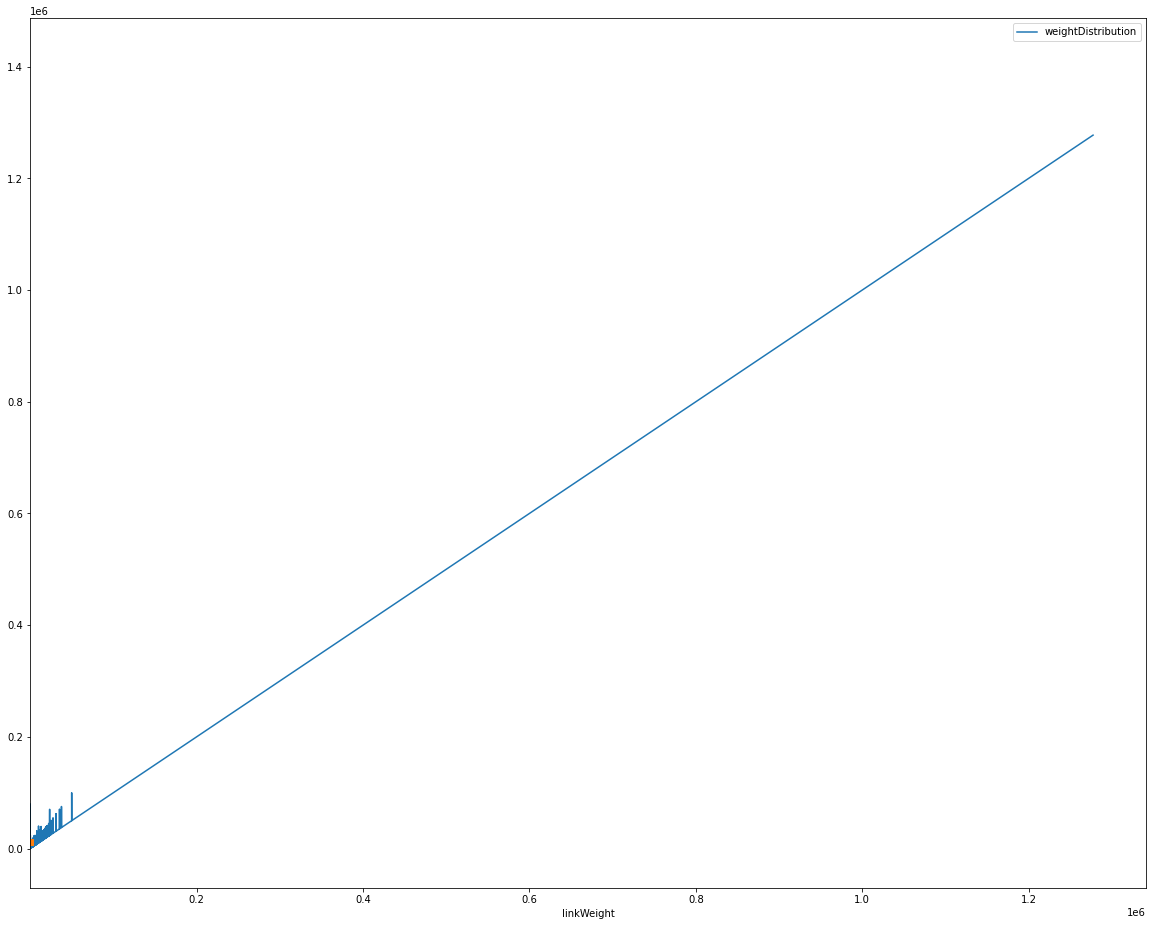

22/06/24 10:23:51 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1494907 ms exceeds timeout 120000 ms
22/06/24 10:23:51 WARN SparkContext: Killing executors is not supported by current scheduler.


In [12]:
import pandas as pd 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize = (20,16))
df_degree = link_weights.toPandas()

df_degree["linkWeight"] = pd.to_numeric(df_degree["linkWeight"], downcast="integer")
df_degree["weightDistribution"] = pd.to_numeric(df_degree["weightDistribution"], downcast="integer")
df_degree.plot(x="linkWeight",y="weightDistribution",ax=axs)
axs.plot(df_degree["linkWeight"].median()*2,"s")
plt.xlim(left=100)